In [ ]:
# GOAL : What am I searching for ?
        # => To predict with the best possible accuracy (proba) an event (+/- xx% variation of close_price)
        # What for ?
            # => To be able to balance my portfolio (sell what should go down for what should go up)
            # => Sell crypto for Stable coin / Or buy crypto with Stable Coin
            
            ######## => Add info about trend 1h, 12h, 24h, 3d, 7d, 15d, 30d, ?
########

In [ ]:
# Advices : 
    # Be careful to scaling, min / max can change in the future...

In [ ]:
# TODO Now :
    # 1 / Industrialization : 
        # Dataset for TOP 20 cryptos + capacity to learn from top 20 and predict 1 : EC - Scikit learn error msg lors du scaling...
        # Test auto de tous les algos pour différentes cryptos et création d'un "rapport" exploitable pour voir ce qui est bien ou non
    # 2 / Construire algo de strategy backtest Buy / Sell + indicateur de stratégie (prendre en compte prévisions d'augmentation et prévisions de baisse)
    # 3 / Gérer le fait qu'on a des dataset déséquilibrés ?
    # 4 / Gérer l'overfitting de ouf

In [ ]:
# TODO : 
    # 0 / Read : What is being done elsewhere, feature enginerring, algo, etc.
    # 1 / Testing phase + take ownership of the code
        # 1.1 / Test y_value and y_classif to be sure it's well calculated
        # 1.2 / Understand well what the code is doing end-to-end
    # 2 / Data vizualisation : Re-read MOOC + articles, what can I do ? Correlations, etc. => Visiblement aime bien les booleans !
    # 3 / Choose features + add with features engineering if needed
        # 3.1 / Other indicators - 10d-20d-30d, etc. ?
        # 3.2 / Add info about trend 1h, 12h, 24h, 3d, 7d, 15d, 30d, etc. ?
        # 3.3 / Volume indicators
    # 4 / Create an automate that can :
        # 4.1 / Test different y, different % increase / deacrease, different algo
        # 4.2 / Try predicting the next hour / next 3h !!! It's stupid to predict +12h whereas I'll have more accurate data after that...
        # 4.3 / Do Gridsearch or other kind of search to find good parameters
        # 4.4 / Export results in a way that they are easy to choose    
    # 5 / Try value instead of classif ?
    # 6 / Try to learn with multiple dataset of different crypto ?
    # 7 / Validation : Find ways to validate models, treshold, proba, etc.
    # 8 / Do TA on bitcoin also when included in crypto dataset
    
    # Try to optimize each algo at a time, see if I can use other algo 
    
# https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05

In [ ]:
# Feature engineering :
    # Add feature : mean 24h price
    # Add feature : mean 24h price - current price

In [1]:
from utils_csa import show_model_accuracy

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split

# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc

#np.set_printoptions(threshold='nan')

importing Jupyter notebook from algocryptos_preprocessing.ipynb


In [2]:
# ------------------ PARAMETERS ------------------ #

# Choose y to be considered
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif',
#       'y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif',
#       'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif',
#       'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "202330" # ether 7605
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}

In [3]:
# ------------------ DATA VIZUALISATION ------------------ #

# correlations (to be done with y to be searched, here not interesting...)
#print(df.close_price.corr(df.reddit_subscribers))
#print(df.close_price.corr(df.reddit_subscribers_slope))
#print(df.close_price.corr(df.volume_aggregated))
#print(df.close_price.corr(df.volume_aggregated_slope))

In [3]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #

# Take one crypto only
#df = alg_preproc.get_global_dataset_for_crypto(id_cryptocompare)
#df2 = df.reset_index(drop=True)
#df2 = df[['open_price', 'high_price', 'low_price', 'close_price','Indic_OBV_uptrend_15d', 'Indic_RSI_14d_uptrend', 'reddit_subscribers_pct_change_7d', 'Indic_RSI_14d_uptrend', 'Indic_EMA_15d_uptrend', 'Indic_EMA_7d_uptrend', 'Indic_Bbands_20d_diff_close_lowerband', 'close_price_variance_15d_tether', 'close_price_pct_change_vs_7d_high', 'volume_aggregated_24h', 'close_price_variance_30d_bitcoin']]

# Take first 10 cryptos
df_list = alg_preproc.get_global_datasets_for_top_n_cryptos(15)

# Find errors in input data - ex - Problem BCH - "202330"
#df_tp = df2.iloc[:,0:123]
#df_tp.reddit_subscribers_pct_change_1d.sort_values()
#tmp = scaler.fit_transform(df_tp)
#df2 = df2.replace([np.inf, -np.inf], np.nan).dropna(how="all")


=> Problème 310829 - TRX sur zscore

Crypto : 1182

Crypto : 5031

Crypto : 7605

Crypto : 202330

Crypto : 166503

Crypto : 4614

Crypto : 3808

Crypto : 171986

Crypto : 321992

Crypto : 204788

Crypto : 5038

Crypto : 310829



C:\Users\cysac\Anaconda3\lib\site-packages\scipy\stats\stats.py:2242: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\cysac\Anaconda3\lib\site-packages\numpy\core\_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


AttributeError: 'numpy.float64' object has no attribute 'sqrt'

In [4]:
# ------------------ PRE-PROCESSING : Calcul y + split data ------------------ #
columns_nb = 0
df_new_list = []

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

# calcul y for each crypto
for df_one_crypto in df_list:
    # number of columns before adding y values - could be done once only
    columns_nb = len(df_one_crypto.columns)

    # calcul all y values we are interested in and add it to the dataframe
    df_one_crypto = calcul_values_of_y(df_one_crypto.copy(), dict_hours_labels, close_price_increase_targeted)

    # remove rows where y can't be calculed (need more data in the future)
    df_one_crypto.dropna(subset=list(df_one_crypto.iloc[:,range(columns_nb, len(df_one_crypto.columns))]), inplace=True)
    df_new_list.append(df_one_crypto)

# concat to get only one dataframe instead of a list of dataframes
df_global = pd.concat(df_new_list).sort_index()
df_global.reset_index(drop=True)

# separe x,y
X = df_global.iloc[:,range(1, columns_nb)]
y = df_global.iloc[:,range(columns_nb, len(df_global.columns))]

# split data in training / validating / testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False)

# TODO : To be used to avoid overitting : No tuning while using testing data, only validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

,open_price,high_price,low_price,close_price,volume_aggregated_1h,volume_aggregated_24h,close_price_variance_3h,close_price_variance_12h,close_price_variance_24h,close_price_variance_7d,...,y_+2d_value,y_+2d_classif,y_+3d_value,y_+3d_classif,y_+7d_value,y_+7d_classif,y_+15d_value,y_+15d_classif,y_+30d_value,y_+30d_classif
0,12818.2000,12851.5300,12445.1300,12629.4300,3.324279e+04,4.749798e+05,1.567368e+04,85615.675269,130552.143945,300174.970271,...,14912.170000,True,14990.810000,True,16722.750000,True,16639.120000,True,16090.6600,True
1,4.7300,4.8700,4.5500,4.8500,3.980668e+06,1.060331e+08,1.213333e-02,0.093929,0.152291,0.324164,...,4.380000,False,4.070000,False,6.220000,True,10.990000,True,9.0500,True
2,0.2260,0.2271,0.2242,0.2252,5.131965e+07,1.173968e+09,4.813333e-06,0.000005,0.000027,0.000027,...,0.229750,False,0.240600,True,0.479200,True,0.961400,True,2.8400,True
3,1419.0150,1424.0750,1407.8100,1409.9450,1.004827e+05,2.837254e+06,1.909066e+01,165.481589,1094.666506,2785.614383,...,1386.470000,False,1404.850000,False,1526.740000,True,3502.740000,True,2397.0400,True
4,1419.9700,1420.6500,1400.5700,1403.0800,1.091232e+05,2.831579e+06,4.712823e+01,181.298189,1035.527435,2781.187599,...,1370.160000,False,1404.700000,False,1547.070000,True,3416.195000,True,2385.3500,True
5,0.2252,0.2272,0.2244,0.2267,3.410371e+07,1.176383e+09,5.833333e-07,0.000005,0.000027,0.000029,...,0.228000,False,0.241400,True,0.470900,True,0.963400,True,2.7700,True
6,4.7800,4.8700,4.6000,4.7600,3.755542e+06,1.072669e+08,3.900000e-03,0.090292,0.148731,0.331309,...,4.280000,False,3.980000,False,6.150000,True,11.290000,True,9.3000,True
7,12628.9900,12747.5100,12625.5700,12726.6000,1.802549e+04,4.773728e+05,8.885905e+03,72997.503608,146716.030565,309131.606302,...,14980.370000,True,14880.210000,True,16863.495000,True,16666.290000,True,15900.5800,True
8,444.0700,446.0000,443.4000,444.0400,1.761629e+05,4.349262e+06,6.622333e-01,10.304671,32.683290,19.758844,...,443.090000,False,482.412500,True,677.800000,True,835.110000,True,990.7600,True
9,444.0400,444.0400,441.0400,442.2600,1.848809e+05,4.344837e+06,1.138900e+00,9.676089,36.919780,21.671885,...,451.790000,False,485.625000,True,686.940000,True,813.520000,True,976.2400,True


----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[16980  3888]
 [  814  4417]]
Accuracy: 0.82
AUC: 0.83


Other Metrics :

             precision    recall  f1-score   support

      False       0.95      0.81      0.88     20868
       True       0.53      0.84      0.65      5231

avg / total       0.87      0.82      0.83     26099

----------------------------------------------------------



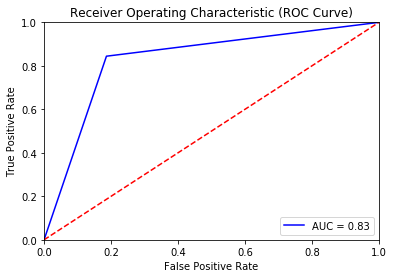

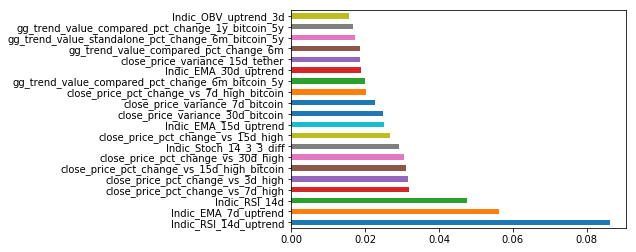

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[7618   54]
 [ 900  128]]
Accuracy: 0.89
AUC: 0.56


Other Metrics :

             precision    recall  f1-score   support

      False       0.89      0.99      0.94      7672
       True       0.70      0.12      0.21      1028

avg / total       0.87      0.89      0.85      8700

----------------------------------------------------------



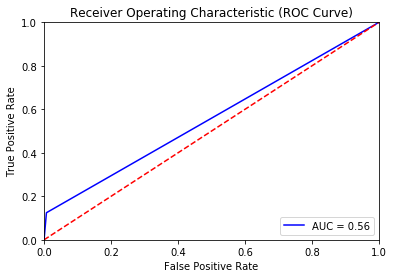

[0.06920053 0.07157116 0.072554   ... 0.59772368 0.59782511 0.64527361]


In [8]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, random_state=0, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced").fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=True)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test_scaled)[:,1]
#print(probas)
print(np.sort(probas))

# clf.decision_path(X_test)

In [8]:
# search for correlations
for col in df3.columns.values:
    if df3[col].corr(df3['y_+1d_classif']) > 0.2:
        print(col + ' - ' + str(df3[col].corr(df3['y_+1d_classif'])))

volume_aggregated_1h - 0.32976151633604567
volume_aggregated_24h - 0.35032276461723194
Indic_RSI_14d - 0.30641338397328405
Indic_Stoch_14_3_3_k - 0.23099848398033185
Indic_Stoch_14_3_3_d - 0.24045150577122887
Indic_OBV - 0.34841634830689094
value_standalone - 0.2701641223569227
value_compared_to_standard - 0.2569874123522578
y_+3h_classif - 0.3634182918366697
y_+6h_classif - 0.34315876472779694
y_+12h_classif - 0.3325067639555313
y_+1d_value - 0.39537671848134487
y_+1d_classif - 1.0
y_+2d_classif - 0.3291205243083935
y_+3d_classif - 0.33294504550471127
y_+7d_classif - 0.32979472066405985
y_+15d_classif - 0.32879878515438365
y_+30d_classif - 0.3348168360661365


----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Train
----------------------------------------------------------

Confusion Matrix :
 [[21732  6435]
 [ 5781 16896]]
Accuracy: 0.76
AUC: 0.76


Other Metrics :

             precision    recall  f1-score   support

      False       0.79      0.77      0.78     28167
       True       0.72      0.75      0.73     22677

avg / total       0.76      0.76      0.76     50844

----------------------------------------------------------



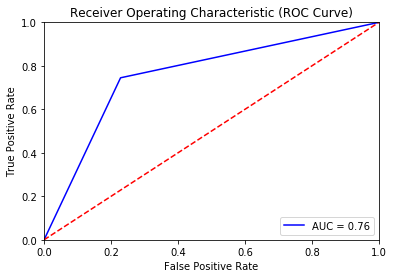

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Test
----------------------------------------------------------

Confusion Matrix :
 [[8079 1364]
 [3163 4342]]
Accuracy: 0.73
AUC: 0.72


Other Metrics :

             precision    recall  f1-score   support

      False       0.72      0.86      0.78      9443
       True       0.76      0.58      0.66      7505

avg / total       0.74      0.73      0.73     16948

----------------------------------------------------------



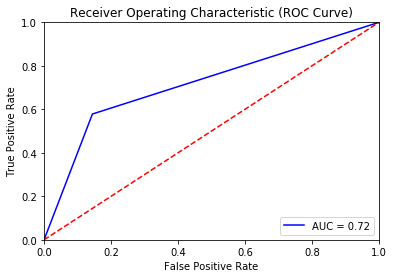

In [9]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

In [27]:
# ------------------ MODEL FITTING ------------------ #

# -----------------------
# ALGO : DUMMY CLASSIFIER
# -----------------------
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('DummyClassifier - Train', dummy_clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns)
show_model_accuracy('DummyClassifier - Test', dummy_clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns)

----------------------------------------------------------
Results for algorithm : DummyClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3896    0]
 [ 965    0]]
Accuracy: 0.80
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.80      1.00      0.89      3896
       True       0.00      0.00      0.00       965

avg / total       0.64      0.80      0.71      4861

----------------------------------------------------------

----------------------------------------------------------
Results for algorithm : DummyClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1483    0]
 [ 138    0]]
Accuracy: 0.91
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.91      1.00      0.96      1483
       True       0.00      0.00      0.00       138

avg / total       0.84      0.91      0.87      1

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Train
----------------------------------------------------------

Confusion Matrix :
 [[2947   91]
 [ 124 1699]]
Accuracy: 0.96
AUC: 0.95


Other Metrics :

             precision    recall  f1-score   support

      False       0.96      0.97      0.96      3038
       True       0.95      0.93      0.94      1823

avg / total       0.96      0.96      0.96      4861

----------------------------------------------------------



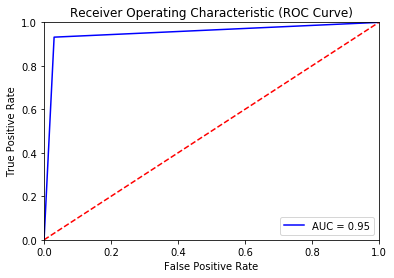

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Test
----------------------------------------------------------

Confusion Matrix :
 [[   0 1327]
 [   0  294]]
Accuracy: 0.18
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.00      0.00      0.00      1327
       True       0.18      1.00      0.31       294

avg / total       0.03      0.18      0.06      1621

----------------------------------------------------------



C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


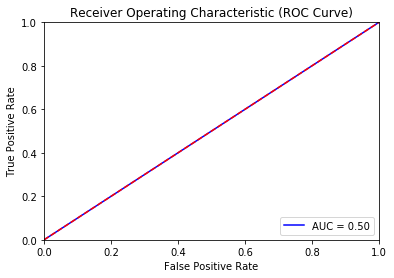

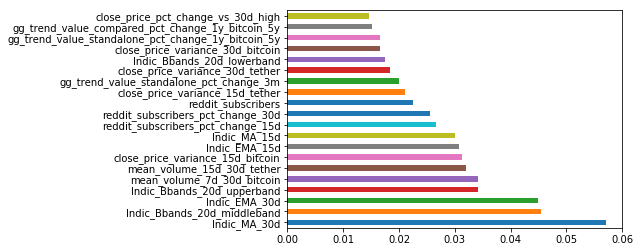

In [21]:
# -----------------------
# ALGO : NAIVE BAYES - GAUSSIANNB
# -----------------------
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('NAIVE BAYES - GaussianNB - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('NAIVE BAYES - GaussianNB - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)


----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3877   19]
 [ 206  759]]
Accuracy: 0.95
AUC: 0.89


Other Metrics :

             precision    recall  f1-score   support

      False       0.95      1.00      0.97      3896
       True       0.98      0.79      0.87       965

avg / total       0.95      0.95      0.95      4861

----------------------------------------------------------



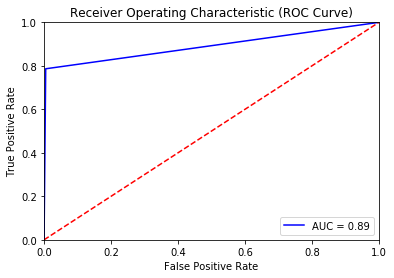

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1326  157]
 [ 111   27]]
Accuracy: 0.83
AUC: 0.54


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.89      0.91      1483
       True       0.15      0.20      0.17       138

avg / total       0.86      0.83      0.85      1621

----------------------------------------------------------



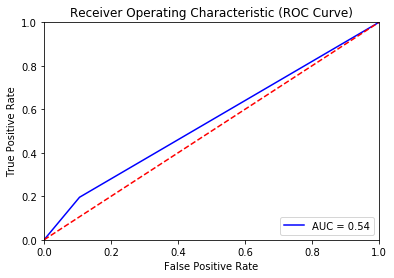

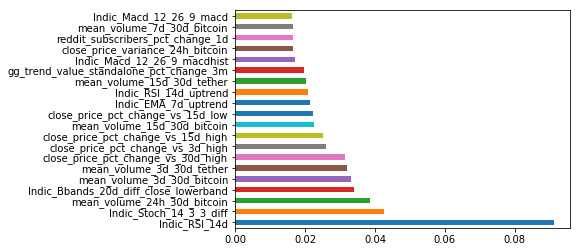

In [29]:
# -----------------------
# ALGO : GradientBoostingClassifier (cf. Module+4 for tuning)
# -----------------------
from sklearn.ensemble import GradientBoostingClassifier

#GradientBoostingClassifier(learning_rate = 0.02, max_depth = 5, random_state = 0)
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('GradientBoostingClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)

----------------------------------------------------------
Results for algorithm : SVM - Train
----------------------------------------------------------

Confusion Matrix :
 [[3778  118]
 [ 275  690]]
Accuracy: 0.92
AUC: 0.84


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.97      0.95      3896
       True       0.85      0.72      0.78       965

avg / total       0.92      0.92      0.92      4861

----------------------------------------------------------



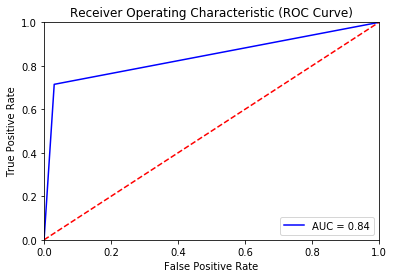

----------------------------------------------------------
Results for algorithm : SVM - Test
----------------------------------------------------------

Confusion Matrix :
 [[1293  190]
 [  99   39]]
Accuracy: 0.82
AUC: 0.58


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.87      0.90      1483
       True       0.17      0.28      0.21       138

avg / total       0.86      0.82      0.84      1621

----------------------------------------------------------



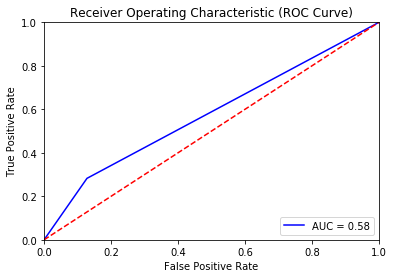

In [31]:
# -----------------------
# ALGO : SVC - (cf. Module+3 for tuning)
# -----------------------
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1).fit(X_train_scaled, y_train[y_to_be_considered])


show_model_accuracy('SVM - Train', svm, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('SVM - Test', svm, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

In [49]:
import seaborn
c = X_train.corr()
#plt.figure(figsize=(10,10))
#seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8))
#plt.show()